In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
IMAGE_BATCH = 256
BATCH_SIZE = 32
CHANNEL = 3
EPOCS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/data-set/PlantVillage",
    shuffle = True,
    image_size = (IMAGE_BATCH,IMAGE_BATCH),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


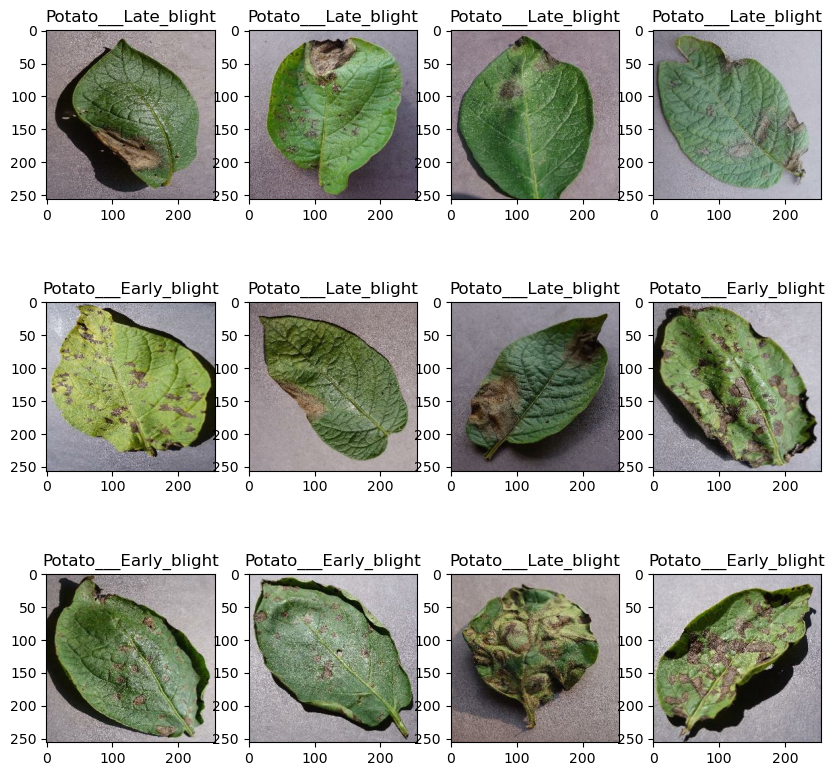

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.title(class_name[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype('uint8'))

In [7]:
def get_dataset_partitions(ds, train_split = 0.8,val_split = 0.1,test_split = 0.1,shuffle = True,shuffle_size = 10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    validation_ds = ds.skip(train_size).take(val_size)
    testing_ds = ds.skip(train_size).skip(val_size)

    return train_ds,testing_ds,validation_ds


In [8]:
train_ds,test_ds,val_ds = get_dataset_partitions(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_BATCH,IMAGE_BATCH),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
input_shape = (BATCH_SIZE, IMAGE_BATCH, IMAGE_BATCH, CHANNEL)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 23s 113ms/step - loss: 0.9151 - accuracy: 0.4861 - val_loss: 0.7937 - val_accuracy: 0.4688
Epoch 2/50
54/54 [==============================] - 3s 55ms/step - loss: 0.7639 - accuracy: 0.6308 - val_loss: 0.6297 - val_accuracy: 0.7031
Epoch 3/50
54/54 [==============================] - 3s 55ms/step - loss: 0.4955 - accuracy: 0.7662 - val_loss: 0.3694 - val_accuracy: 0.8333
Epoch 4/50
54/54 [==============================] - 3s 54ms/step - loss: 0.3941 - accuracy: 0.8490 - val_loss: 0.2983 - val_accuracy: 0.8854
Epoch 5/50
54/54 [==============================] - 3s 56ms/step - loss: 0.2639 - accuracy: 0.8929 - val_loss: 0.3283 - val_accuracy: 0.8854
Epoch 6/50
54/54 [==============================] - 3s 55ms/step - loss: 0.2035 - accuracy: 0.9196 - val_loss: 0.1754 - val_accuracy: 0.9271
Epoch 7/50
54/54 [==============================] - 3s 55ms/step - loss: 0.1480 - accuracy: 0.9427 - val_loss: 0.1450 - val_accuracy: 0.9323
Epoch 8/50


In [16]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 28ms/step - loss: 0.1003 - accuracy: 0.9844


In [17]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [18]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validation loss')

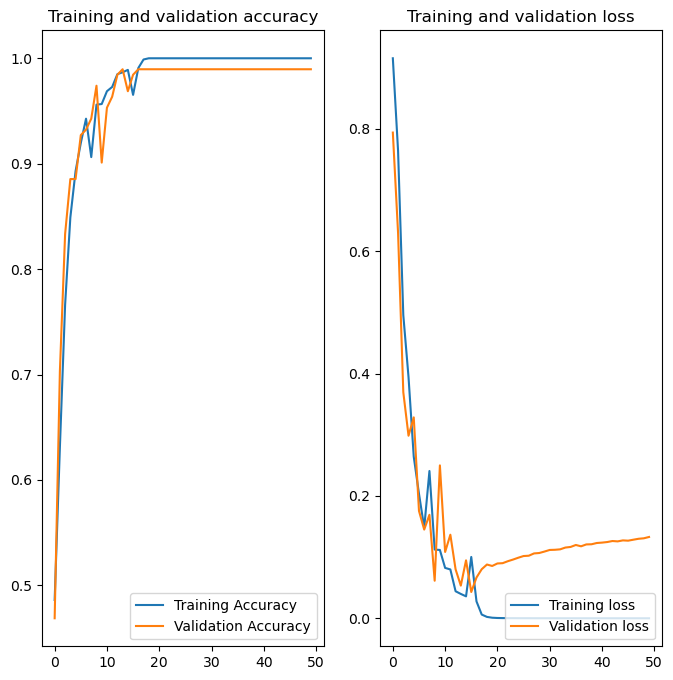

In [20]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCS),acc,label = 'Training Accuracy')
plt.plot(range(EPOCS),val_acc,label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCS),loss,label = 'Training loss')
plt.plot(range(EPOCS),val_loss,label = 'Validation loss')
plt.legend(loc = 'lower right')
plt.title('Training and validation loss')

In [21]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[129. 121. 134.]
  [123. 115. 128.]
  [116. 108. 121.]
  ...
  [ 99.  89. 100.]
  [ 99.  89. 100.]
  [ 96.  86.  97.]]

 [[117. 109. 122.]
  [116. 108. 121.]
  [115. 107. 120.]
  ...
  [ 90.  80.  91.]
  [ 94.  84.  95.]
  [ 96.  86.  97.]]

 [[112. 104. 117.]
  [112. 104. 117.]
  [112. 104. 117.]
  ...
  [ 85.  75.  86.]
  [ 91.  81.  92.]
  [ 94.  84.  95.]]

 ...

 [[150. 140. 149.]
  [150. 140. 149.]
  [149. 139. 148.]
  ...
  [141. 131. 142.]
  [140. 130. 141.]
  [140. 130. 141.]]

 [[148. 138. 147.]
  [148. 138. 147.]
  [148. 138. 147.]
  ...
  [141. 131. 142.]
  [140. 130. 141.]
  [138. 128. 139.]]

 [[147. 137. 146.]
  [147. 137. 146.]
  [147. 137. 146.]
  ...
  [139. 129. 140.]
  [136. 126. 137.]
  [133. 123. 134.]]]


first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 183ms/step
predicted label: Potato___Early_blight


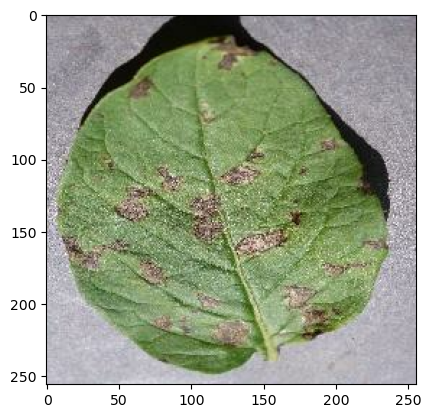

In [22]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


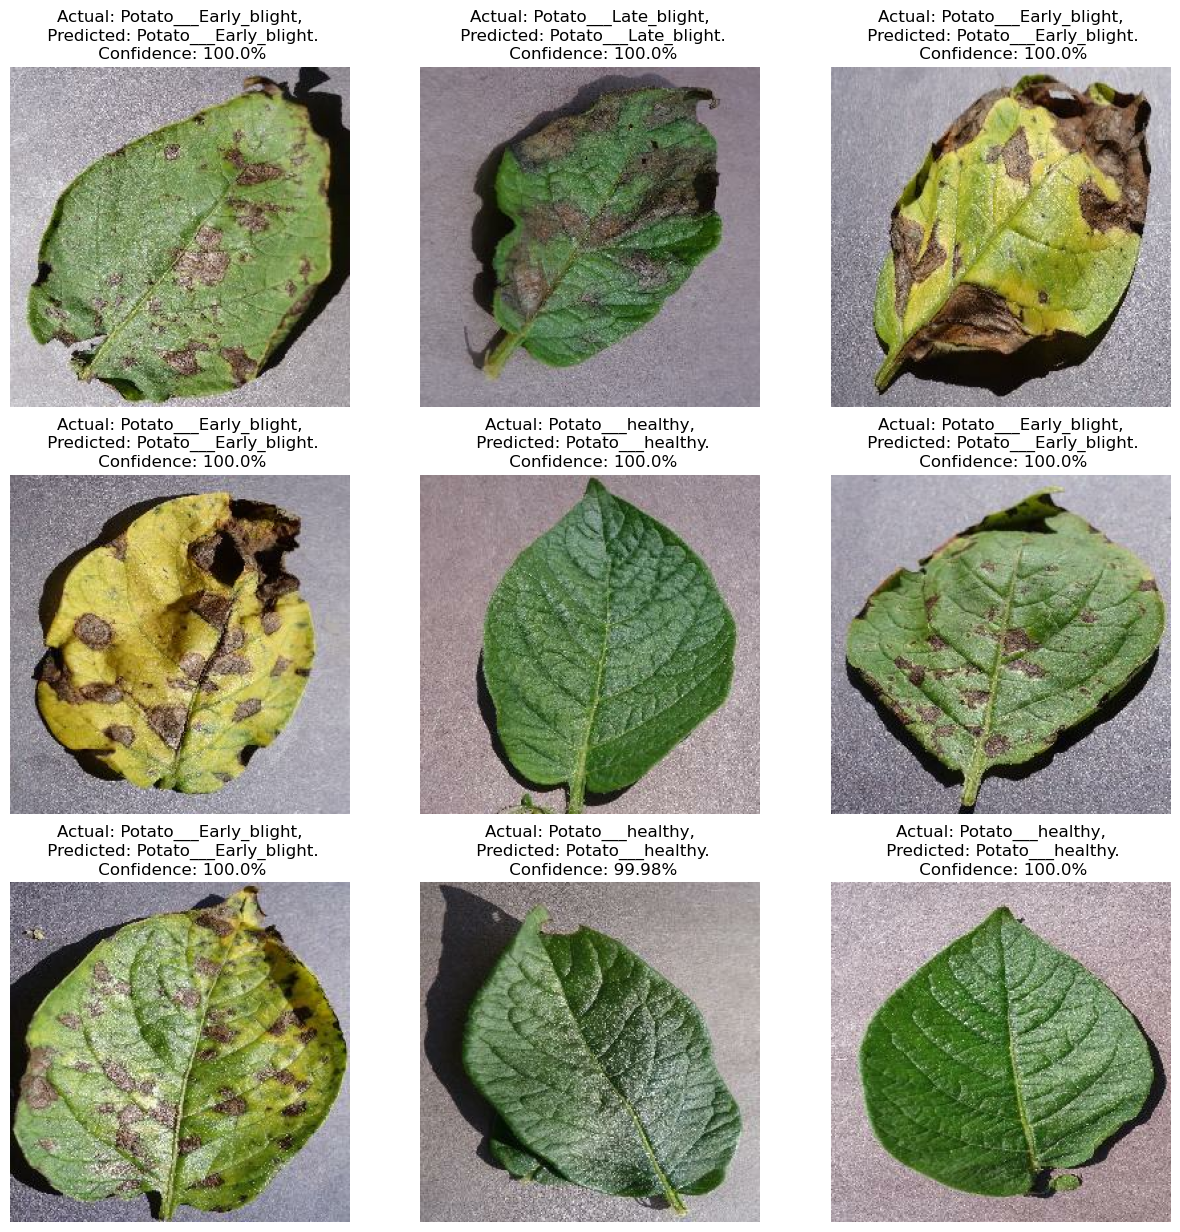

In [24]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [25]:
model_version = 1
model.save(f"/kaggle/working/models/{model_version}")